In [1]:
from sys import path
path.append('../src')

from data_loading import *

/home/carlos/Documents/python/environments/pytorchenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch.utils.data import Dataset, ConcatDataset, DataLoader, WeightedRandomSampler

from torchvision.transforms import ToTensor
from torchvision import datasets, transforms

In [3]:
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 0
PIN_MEMORY = True

In [4]:
chest_path, nih_path = download_datasets()
print("Path to chest x-ray dataset files:", chest_path)
print("Path to NIH chest x-ray dataset files:", nih_path)

Path to chest x-ray dataset files: /home/carlos/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2
Path to NIH chest x-ray dataset files: /home/carlos/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3


In [5]:
K_TRAIN, K_VAL, K_TEST, NIH_LABELS, NIH_TVLIST, NIH_TLIST, NIH_IMAGE_DIRS = get_paths(chest_path, nih_path)

Directory exists: /home/carlos/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray
Contents: ['test', 'train', 'val', '__MACOSX', 'chest_xray']
Directory exists: /home/carlos/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3
Contents: ['train_val_list.txt', 'images_003', 'LOG_CHESTXRAY.pdf', 'images_008', 'images_009', 'images_006', 'images_007', 'BBox_List_2017.csv', 'images_012', 'images_010', 'images_001', 'Data_Entry_2017.csv', 'images_005', 'ARXIV_V5_CHESTXRAY.pdf', 'images_004', 'README_CHESTXRAY.pdf', 'FAQ_CHESTXRAY.pdf', 'test_list.txt', 'images_011', 'images_002']


In [6]:
# -----------------
# Transforms
# -----------------

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=7),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

In [7]:
# -----------------
# Kaggle datasets (ImageFolder)
# -----------------
k_train_ds = datasets.ImageFolder(str(K_TRAIN), transform=train_tfms)
k_val_ds   = datasets.ImageFolder(str(K_VAL),   transform=eval_tfms)
k_test_ds  = datasets.ImageFolder(str(K_TEST),  transform=eval_tfms)

# Sanity: classes should be ['NORMAL', 'PNEUMONIA'] in that order
print("Kaggle classes:", k_train_ds.classes)

Kaggle classes: ['NORMAL', 'PNEUMONIA']


In [8]:
nih_train_items, nih_val_items, nih_test_items = make_nih_binary_splits(
    NIH_IMAGE_DIRS, NIH_LABELS, NIH_TVLIST, NIH_TLIST, 
    val_ratio=0.10, test_ratio=0.10, seed=42
)

[NIH] Indexed 112,120 image files from 12 dirs.
NIH (official lists): tv=51376 test=10416 → train=46238 val=5138


In [9]:
nih_train_ds = NIHBinaryDataset(nih_train_items, transform=train_tfms)
nih_val_ds   = NIHBinaryDataset(nih_val_items,   transform=eval_tfms)
nih_test_ds  = NIHBinaryDataset(nih_test_items,  transform=eval_tfms)

print(f"NIH counts — train:{len(nih_train_ds)}  val:{len(nih_val_ds)}  test:{len(nih_test_ds)}")

NIH counts — train:46238  val:5138  test:10416


In [10]:
# -----------------
# Merge Kaggle + NIH per split
# -----------------
train_ds = ConcatDataset([k_train_ds, nih_train_ds])
val_ds   = ConcatDataset([k_val_ds,   nih_val_ds])
test_ds  = ConcatDataset([k_test_ds,  nih_test_ds])

In [11]:
train_targets = concat_targets(train_ds)

In [12]:
balanced_sampler = balance_classes(train_targets, 2, train_ds)

In [13]:
use_cutmix   = False   # toggle if you want CutMix at batch time
p_cutmix     = 0.5
alpha_cutmix = 1.0
train_collate = CutMixCollate(alpha=alpha_cutmix, p_cutmix=p_cutmix, seed=42) if use_cutmix else None

In [14]:
# -----------------
# DataLoaders
# -----------------
train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=False,   # shuffle False because sampler drives ordering
    sampler=balanced_sampler,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
    collate_fn=train_collate
)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

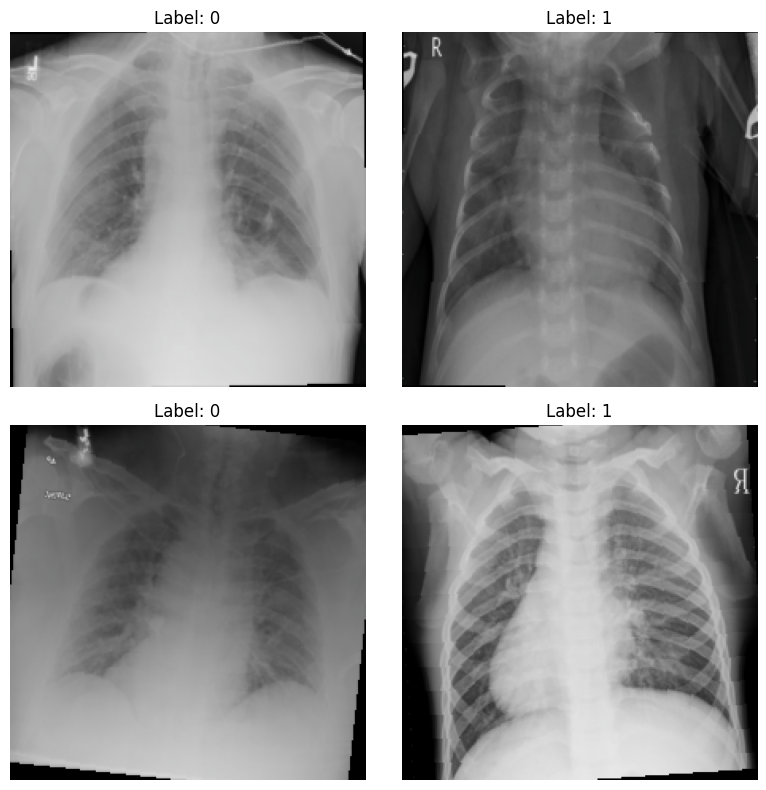

In [ ]:
# Draw 4 samples from the train loader and display them in a 2x2 grid
import matplotlib.pyplot as plt
import numpy as np

batch = next(iter(train_loader))
if isinstance(batch, dict) and batch.get("is_cutmix", False):
    xb, yb = batch["images"], batch["targets"]
else:
    xb, yb = batch

images = xb[:4]
labels = yb[:4]

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    img = images[i].cpu().numpy().transpose(1, 2, 0)
    # Undo normalization for display (ImageNet stats)
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis('off')
plt.tight_layout()
plt.show()# DataLoaders